<a href="https://colab.research.google.com/github/sidharthsinha/Retinal-OCT-Classifier/blob/main/OCT_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download paultimothymooney/kermany2018

100% 10.8G/10.8G [04:05<00:00, 92.6MB/s]
100% 10.8G/10.8G [04:05<00:00, 47.4MB/s]


In [6]:
! unzip kermany2018.zip

Streaming output truncated to the last 5000 lines.
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8050636-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-4.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-5.jpeg  
  inflating: 

(496, 512)


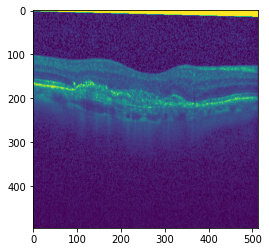

In [7]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
img = plt.imread("/content/OCT2017 /train/CNV/CNV-1016042-1.jpeg")
%matplotlib inline
print(img.shape)
plt.imshow(img)



In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
image_path = "/content/OCT2017 /"

mean = [0.224, 0.224, 0.224]
std = [0.1551, 0.1551, 0.1551]

input_size = 32

batch_size = 16
num_epochs = 10

train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((input_size, input_size)),
      transforms.Normalize((mean), (std))                              
])

val_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((input_size, input_size)),
      transforms.Normalize((mean), (std))
])

test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((input_size, input_size)),
      transforms.Normalize((mean), (std))
])

train_ds = torchvision.datasets.ImageFolder(os.path.join(image_path, 'train'), train_transform)
val_ds = torchvision.datasets.ImageFolder(os.path.join(image_path, 'val'), val_transform)
test_ds = torchvision.datasets.ImageFolder(os.path.join(image_path, 'test'), test_transform)

In [11]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
import torch.nn.functional as F

def accuracy(outputs, labels):
    max_probs, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class imageclassification(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
class octnnmodel(imageclassification):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
  def forward(self, xb):
    return self.network(xb)

In [15]:
model = octnnmodel()

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [18]:
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0], train_loss: 0.6116, val_loss: 0.4008, val_acc: 0.8438
Epoch [1], train_loss: 0.4217, val_loss: 0.3390, val_acc: 0.8750
Epoch [2], train_loss: 0.3698, val_loss: 0.3512, val_acc: 0.8438
Epoch [3], train_loss: 0.3416, val_loss: 0.3130, val_acc: 0.9062
Epoch [4], train_loss: 0.3178, val_loss: 0.2338, val_acc: 0.9375
Epoch [5], train_loss: 0.3028, val_loss: 0.2043, val_acc: 0.9375
Epoch [6], train_loss: 0.3623, val_loss: 0.2836, val_acc: 0.8438
Epoch [7], train_loss: 0.2752, val_loss: 0.2714, val_acc: 0.9062
Epoch [8], train_loss: 0.4054, val_loss: 0.2404, val_acc: 0.9375
Epoch [9], train_loss: 0.2476, val_loss: 0.2253, val_acc: 0.9688


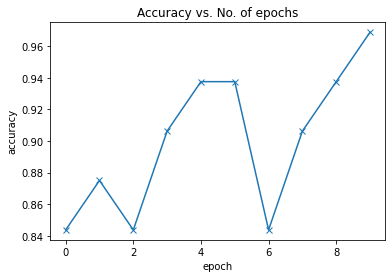

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)